# Random Forest Regression Algorithm - Preprocessed Data Training

In [15]:
# Importing the libraries
import time
import numpy as np # for array operations
import pandas as pd # for working with DataFrames

# scikit-learn modules
from sklearn.model_selection import train_test_split # for splitting the data
from sklearn.metrics import mean_squared_error # for calculating the cost function
from sklearn.ensemble import RandomForestRegressor # for building the model

In [16]:
DATE_TIME_COLUMNS = ['DATETIME_INI', 'DATETIME_FIM']

dataset = pd.read_csv('../../../data/preprocessed.csv', index_col='PES_ID', parse_dates=DATE_TIME_COLUMNS)

## Required Preprocessing

In [17]:
dataset["DATETIME_INI"] = dataset["DATETIME_INI"].apply(lambda x: time.mktime(x.timetuple()))
dataset["DATETIME_FIM"] = dataset["DATETIME_FIM"].apply(lambda x: time.mktime(x.timetuple()))

In [ ]:
dataset.head()

## Training

In [18]:
x = dataset.drop('PES_PESOUTIL', axis = 1) # Features
y = dataset['PES_PESOUTIL']  # Target

In [19]:
# Splitting the dataset into training and testing set (70/30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

### Parameterizing

In [ ]:
# from sklearn.model_selection import GridSearchCV

# # set up our search grid
# param_grid = {"n_estimators": [1, 10, 50],
#               "criterion": ["squared_error", "mean_squared_error", "absolute_error"],
#               "max_depth": [4, 5, 6]
# }

# rfr_model = RandomForestRegressor()

# # try out every combination of the above values
# search = GridSearchCV(rfr_model, param_grid, cv=10, error_score='raise').fit(x_train, y_train)

# print("The best hyperparameters are ",search.best_params_)


In [20]:
params = {
    'n_estimators': 50,
    'criterion': 'squared_error',
    'max_depth': 5,
    'random_state': 0,
}

In [21]:
# Initializing the Random Forest Regression model with 10 decision trees
model = RandomForestRegressor(**params)

# Fitting the Random Forest Regression model to the data
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)

In [22]:
# MSE (Mean Squared Error)
mse = mean_squared_error(y_test, model.predict(x_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 7326296.5197


## Cross-Validation

In [23]:
import random
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import ShuffleSplit

def cross_validate_model(model, X, y, cv=10):
    cv = ShuffleSplit(n_splits=cv, test_size=0.3, random_state=random.randint(0, 1000))
    n_scores = cross_validate(estimator=model,
                            X=X,
                            y=y,
                            cv=cv,
                            scoring=('r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True)
    return n_scores

## Experimentation

In [24]:
N_ITERATIONS = 5
N_CROSS_VALIDATION = 10

n_scores = []
duration = []

for _ in range(N_ITERATIONS):
    time_start = time.time()
    n_scores.append(cross_validate_model(model, x, y, cv=N_CROSS_VALIDATION))
    duration.append(time.time() - time_start)

### Training Duration

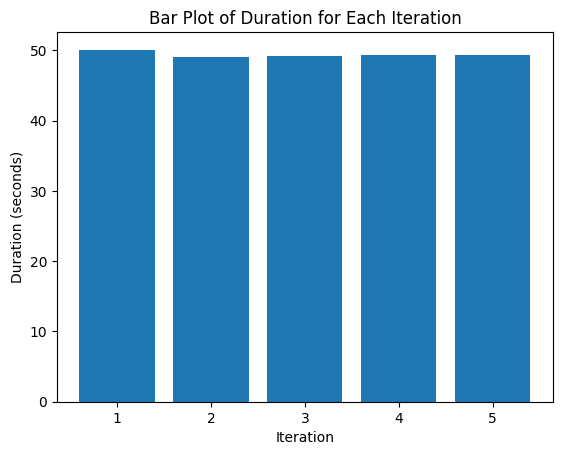

In [25]:
import matplotlib.pyplot as plt

# Create a bar plot
plt.bar(range(1,len(duration)+1), duration)
plt.xlabel('Iteration')
plt.ylabel('Duration (seconds)')
plt.title('Bar Plot of Duration for Each Iteration')
plt.show()


### R² Score

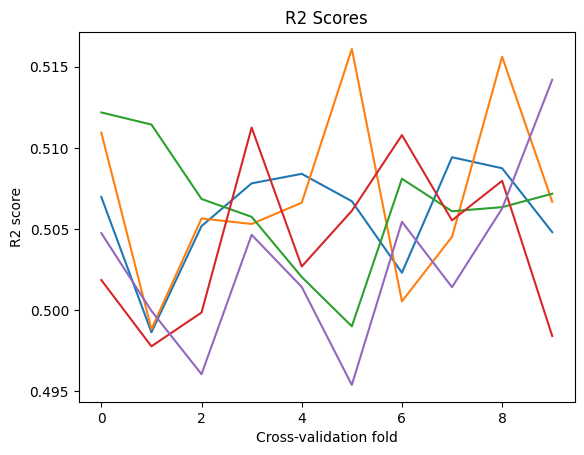

In [26]:
import matplotlib.pyplot as plt

# Reshape the R2 scores
r2_scores = [r2['test_r2'].reshape(-1, 1) for r2 in n_scores]

# Plot the R2 scores
[plt.plot(r2_score, label=f'Fold {i + 1}') for i, r2_score in enumerate(r2_scores)]
plt.xlabel('Cross-validation fold')
plt.ylabel('R2 score')
plt.title('R2 Scores')
plt.show()

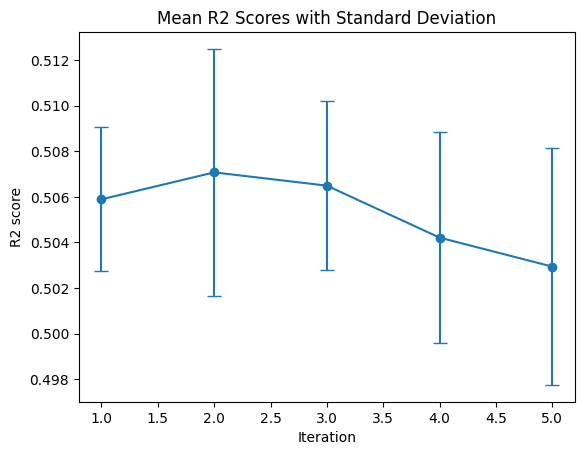

Mean R2: 0.5053
Standard Deviation of R2: 0.0015


In [27]:
# Calculate mean and standard deviation of R2 scores
mean_r2_scores = [r2['test_r2'].mean() for r2 in n_scores]
std_r2_scores = [r2['test_r2'].std() for r2 in n_scores]

# Plot the mean R2 scores with error bars representing the standard deviation
plt.errorbar(range(1, N_ITERATIONS + 1), mean_r2_scores, yerr=std_r2_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('Iteration')
plt.ylabel('R2 score')
plt.title('Mean R2 Scores with Standard Deviation')
plt.show()

mean_r2 = sum(mean_r2_scores) / len(mean_r2_scores)
std_mse = np.std(mean_r2_scores)

print("Mean R2: {:.4f}".format(mean_r2))
print("Standard Deviation of R2: {:.4f}".format(std_mse))

### MSE

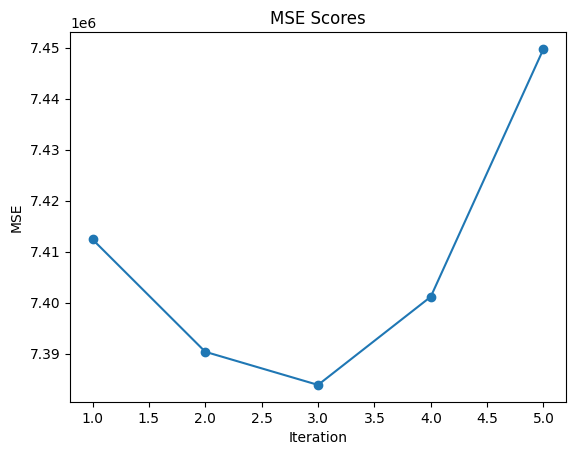

Mean MSE: 7407490.0275
Standard Deviation of MSE: 23251.1633


In [28]:
# Calculate MSE for each fold
mse_scores = [-r2['test_neg_mean_squared_error'].mean() for r2 in n_scores]

# Plot the MSE scores
plt.plot(range(1, N_ITERATIONS + 1), mse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('MSE Scores')
plt.show()

# Calculate mean and standard deviation of MSE scores
mean_mse = sum(mse_scores) / len(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE: {:.4f}".format(mean_mse))
print("Standard Deviation of MSE: {:.4f}".format(std_mse))

### RMSE

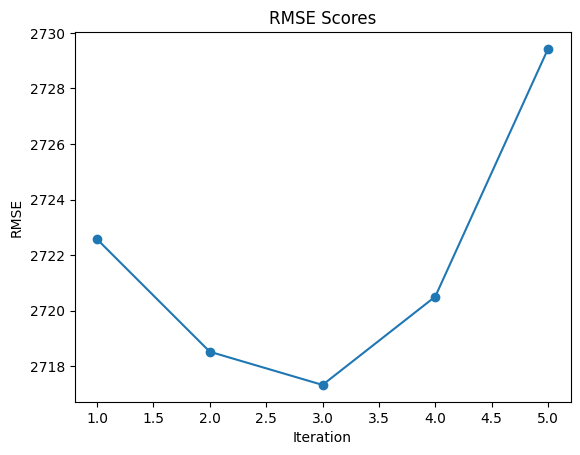

Mean RMSE: 2721.6671
Standard Deviation of RMSE: 4.2685


In [29]:
rmse_scores = [np.sqrt(-r2['test_neg_mean_squared_error'].mean()) for r2 in n_scores]

# Plot the RMSE scores
plt.plot(range(1, N_ITERATIONS + 1), rmse_scores, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('RMSE Scores')
plt.show()

# Calculate mean and standard deviation of RMSE scores
mean_rmse = sum(rmse_scores) / len(rmse_scores)
std_rmse = np.std(rmse_scores)

print("Mean RMSE: {:.4f}".format(mean_rmse))
print("Standard Deviation of RMSE: {:.4f}".format(std_rmse))

## Exporting Metrics

In [30]:
import os

# Define the filename for the metrics dataset
metrics_filename = "../results.csv"

# Check if the metrics.csv file exists
if os.path.exists(metrics_filename):
    # Load the metrics dataset
    metrics_dataset = pd.read_csv(metrics_filename, index_col='Algorithm')
    
    data = {
        "Mean R2 score": mean_r2,
        "Standard deviation of R2 scores": std_mse,
        "Mean MSE": mean_mse,
        "Standard deviation of MSE": std_mse,
        "Mean RMSE": mean_rmse,
        "Standard deviation of RMSE": std_rmse
    }
    
    df = pd.DataFrame(data, index=['RandomForestRegressor_preprocessed'])
    
    metrics_dataset = pd.concat([metrics_dataset, df], axis=0)
    
    # Save the updated metrics dataset
    metrics_dataset.to_csv(metrics_filename, index=True, index_label='Algorithm')
else:
    # The metrics.csv file does not exist, print an error message
    print("The metrics.csv file does not exist.")